In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [1]:
#Load and Inspect Data
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, count, avg, sum, desc

# Initialize Spark Session
spark = SparkSession.builder.appName("AmazonDataAnalysis").getOrCreate()

# Load CSV File
file_path = "/kaggle/input/unlock-profits-with-e-commerce-sales-data/Amazon Sale Report.csv"  # Path to your uploaded file
df = spark.read.format("csv").option("header", True).option("inferSchema", True).load(file_path)

# Show sample data
df.show(5, truncate=False)
df.printSchema()


+-----+-------------------+--------+----------------------------+----------+--------------+------------------+-------+---------------+-------------+----+----------+--------------+---+--------+------+-----------+-----------+----------------+------------+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

In [2]:
# Check for Missing Values
from pyspark.sql.functions import isnan, when, count

df.select([count(when(col(c).isNull(), c)).alias(c) for c in df.columns]).show()


+-----+--------+----+------+----------+--------------+------------------+-----+---+--------+----+----+--------------+---+--------+------+---------+----------+----------------+------------+-------------+---+------------+-----------+
|index|Order ID|Date|Status|Fulfilment|Sales Channel |ship-service-level|Style|SKU|Category|Size|ASIN|Courier Status|Qty|currency|Amount|ship-city|ship-state|ship-postal-code|ship-country|promotion-ids|B2B|fulfilled-by|Unnamed: 22|
+-----+--------+----+------+----------+--------------+------------------+-----+---+--------+----+----+--------------+---+--------+------+---------+----------+----------------+------------+-------------+---+------------+-----------+
|    0|       0|   0|     0|         0|             0|                 0|    0|  0|       0|   0|   0|          6872|  0|    7795|  7795|       33|        33|              33|          33|        49153|  0|       89698|      49050|
+-----+--------+----+------+----------+--------------+------------------

In [3]:
#Count of Orders by Status
df.groupBy("Status").count().orderBy(desc("count")).show()


+--------------------+-----+
|              Status|count|
+--------------------+-----+
|             Shipped|77804|
|Shipped - Deliver...|28769|
|           Cancelled|18332|
|Shipped - Returne...| 1953|
| Shipped - Picked Up|  973|
|             Pending|  658|
|Pending - Waiting...|  281|
|Shipped - Returni...|  145|
|Shipped - Out for...|   35|
|Shipped - Rejecte...|   11|
|            Shipping|    8|
|Shipped - Lost in...|    5|
|   Shipped - Damaged|    1|
+--------------------+-----+



In [4]:
#Top 5 Best-Selling Product Categories
df.groupBy("Category").count().orderBy(desc("count")).show(5)


+-------------+-----+
|     Category|count|
+-------------+-----+
|          Set|50284|
|        kurta|49877|
|Western Dress|15500|
|          Top|10622|
| Ethnic Dress| 1159|
+-------------+-----+
only showing top 5 rows



In [5]:
#Total Revenue & Average Order Amount
df.select(sum("Amount").alias("Total Revenue"), avg("Amount").alias("Avg Order Value")).show()


+-------------------+-----------------+
|      Total Revenue|  Avg Order Value|
+-------------------+-----------------+
|7.859267829999988E7|648.5614647631612|
+-------------------+-----------------+



In [6]:
#Top 5 Shipping Cities with the Most Orders
df.groupBy("ship-city").count().orderBy(desc("count")).show(5)


+---------+-----+
|ship-city|count|
+---------+-----+
|BENGALURU|11217|
|HYDERABAD| 8074|
|   MUMBAI| 6126|
|NEW DELHI| 5795|
|  CHENNAI| 5421|
+---------+-----+
only showing top 5 rows



In [7]:
#Top 5 Shipping States with the Most Orders
df.groupBy("ship-state").count().orderBy(desc("count")).show(5)


+-------------+-----+
|   ship-state|count|
+-------------+-----+
|  MAHARASHTRA|22260|
|    KARNATAKA|17326|
|   TAMIL NADU|11483|
|    TELANGANA|11330|
|UTTAR PRADESH|10638|
+-------------+-----+
only showing top 5 rows



In [8]:
#DATA CLEANING(Remove Nulls)
df_clean = df.na.drop()
df_clean.show(5)


+-----+-------------------+--------+--------------------+----------+--------------+------------------+-------+--------------+-------------+----+----------+--------------+---+--------+------+----------------+---------------+----------------+------------+--------------------+-----+------------+-----------+
|index|           Order ID|    Date|              Status|Fulfilment|Sales Channel |ship-service-level|  Style|           SKU|     Category|Size|      ASIN|Courier Status|Qty|currency|Amount|       ship-city|     ship-state|ship-postal-code|ship-country|       promotion-ids|  B2B|fulfilled-by|Unnamed: 22|
+-----+-------------------+--------+--------------------+----------+--------------+------------------+-------+--------------+-------------+----+----------+--------------+---+--------+------+----------------+---------------+----------------+------------+--------------------+-----+------------+-----------+
|49051|408-4858463-2356347|05-31-22|Shipped - Deliver...|  Merchant|     Amazon.in

In [9]:
#DATA CLEANING(Remove Duplicates)
df_clean = df_clean.dropDuplicates()
df_clean.show(5)


+-----+-------------------+--------+--------------------+----------+--------------+------------------+-------+--------------+-------------+----+----------+--------------+---+--------+------+----------+--------------+----------------+------------+--------------------+-----+------------+-----------+
|index|           Order ID|    Date|              Status|Fulfilment|Sales Channel |ship-service-level|  Style|           SKU|     Category|Size|      ASIN|Courier Status|Qty|currency|Amount| ship-city|    ship-state|ship-postal-code|ship-country|       promotion-ids|  B2B|fulfilled-by|Unnamed: 22|
+-----+-------------------+--------+--------------------+----------+--------------+------------------+-------+--------------+-------------+----+----------+--------------+---+--------+------+----------+--------------+----------------+------------+--------------------+-----+------------+-----------+
|49081|402-7031777-0396341|05-31-22|Shipped - Deliver...|  Merchant|     Amazon.in|          Standard|J

In [10]:
#Convert PySpark DataFrame to Pandas for Visualization
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Convert PySpark DataFrame to Pandas for visualization
df_pd = df_clean.toPandas()

# Set seaborn style
sns.set(style="whitegrid")


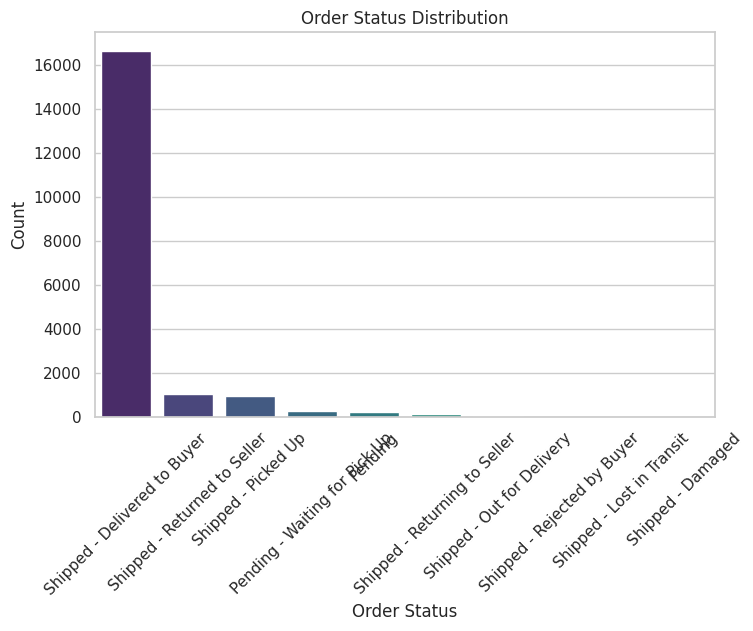

In [11]:
#Order Status Distribution (Bar Chart)
lt.figure(figsize=(8, 5))
sns.countplot(data=df_pd, x="Status", order=df_pd["Status"].value_counts().index, palette="viridis")
plt.title("Order Status Distribution")
plt.xticks(rotation=45)
plt.xlabel("Order Status")
plt.ylabel("Count")
plt.show()


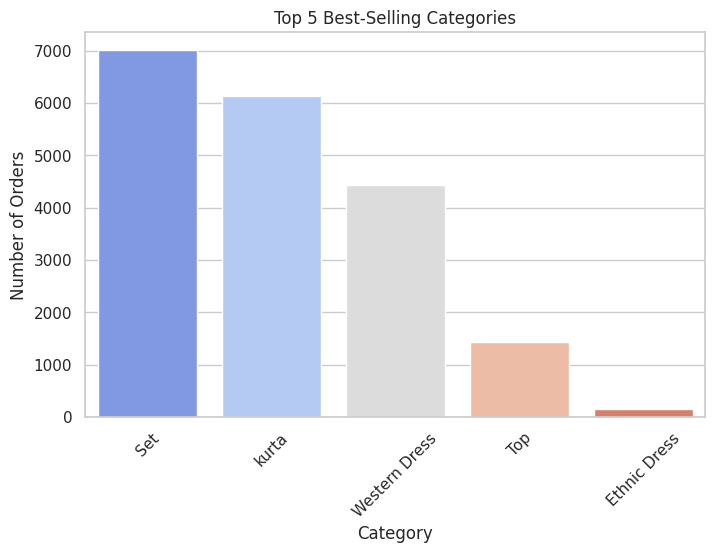

In [12]:
#Top 5 Best-Selling Categories (Bar Chart)
plt.figure(figsize=(8, 5))
top_categories = df_pd["Category"].value_counts().nlargest(5)
sns.barplot(x=top_categories.index, y=top_categories.values, palette="coolwarm")
plt.title("Top 5 Best-Selling Categories")
plt.xlabel("Category")
plt.ylabel("Number of Orders")
plt.xticks(rotation=45)
plt.show()


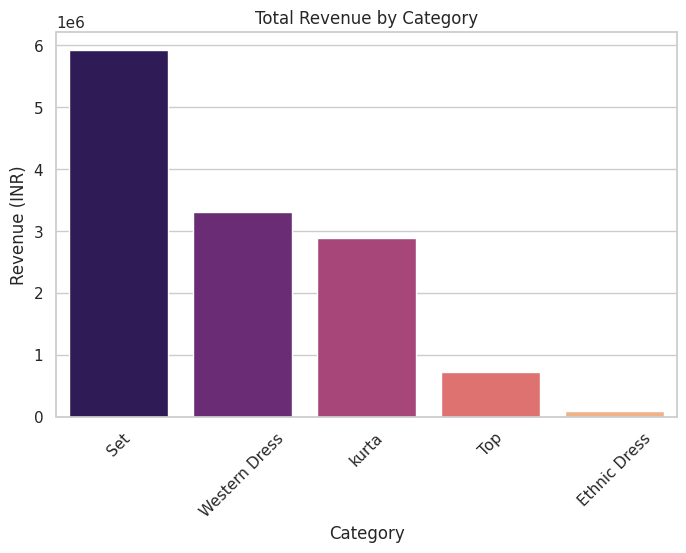

In [13]:
#Total Revenue by Category (Bar Chart)
plt.figure(figsize=(8, 5))
category_revenue = df_pd.groupby("Category")["Amount"].sum().nlargest(5)
sns.barplot(x=category_revenue.index, y=category_revenue.values, palette="magma")
plt.title("Total Revenue by Category")
plt.xlabel("Category")
plt.ylabel("Revenue (INR)")
plt.xticks(rotation=45)
plt.show()


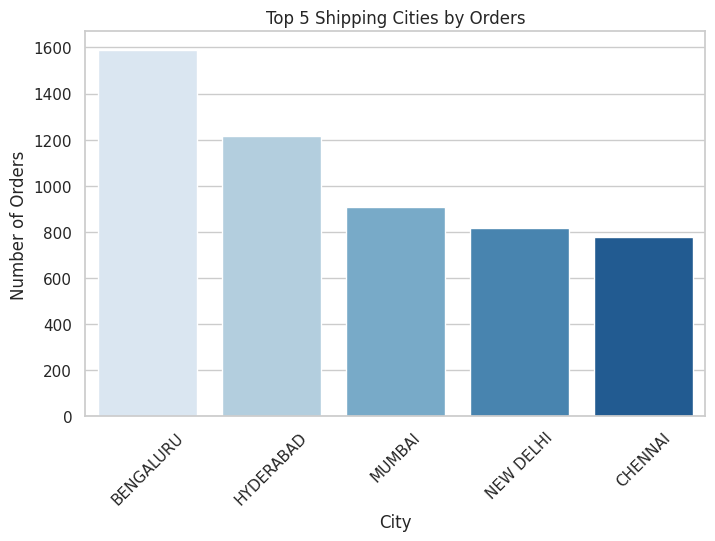

In [14]:
#Top 5 Shipping Cities with the Most Orders
plt.figure(figsize=(8, 5))
top_cities = df_pd["ship-city"].value_counts().nlargest(5)
sns.barplot(x=top_cities.index, y=top_cities.values, palette="Blues")
plt.title("Top 5 Shipping Cities by Orders")
plt.xlabel("City")
plt.ylabel("Number of Orders")
plt.xticks(rotation=45)
plt.show()


/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


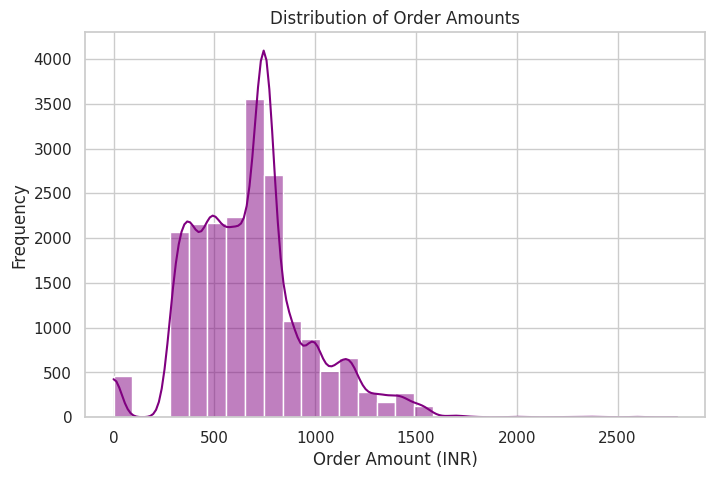

In [15]:
#Distribution of Order Amounts (Histogram)


plt.figure(figsize=(8, 5))
sns.histplot(df_pd["Amount"], bins=30, kde=True, color="purple")
plt.title("Distribution of Order Amounts")
plt.xlabel("Order Amount (INR)")
plt.ylabel("Frequency")
plt.show()
